## **Enhancing Bangla Number Plate Detection with RTDetr**

This notebook is part of our research on enhanced Bangla number plate detection. It outlines the environment setup, dataset preparation, model initialization, training with PyTorch Lightning, evaluation, and video inference using RTDetr.

### **1. Environment Setup**
Defines the project home directory and displays device information (OS path, Torch and CUDA versions).

In [1]:
%cd /home/iot/bd-lpr-rtdetr-trocr-swin2sr

/home/iot/bd-lpr-rtdetr-trocr-swin2sr


In [2]:
import os
HOME = os.getcwd()
print("Project Root Directory:", HOME)

Project Root Directory: /home/iot/bd-lpr-rtdetr-trocr-swin2sr


In [3]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "\ncuda: ", CUDA_VERSION)

torch:  2.7 
cuda:  cu126


### **2. Dependency Imports**
Imports necessary libraries (Roboflow, Supervision, Transformers, PyTorch Lightning) and prints their versions.

In [4]:
import roboflow
import torchvision
import supervision
import transformers
import pytorch_lightning
print(
    "roboflow:", roboflow.__version__,
    "\nsupervision:", supervision.__version__,
    "\ntorchvision:", torchvision.__version__,
    "\ntransformers:", transformers.__version__,
    "\npytorch_lightning:", pytorch_lightning.__version__
)

roboflow: 1.1.64 
supervision: 0.5.1 
torchvision: 0.22.0+cu126 
transformers: 4.51.3 
pytorch_lightning: 2.5.1.post0


### **3. Model Initialization**
Loads the RTDETR image processor and object detection model from a pretrained checkpoint, then moves the model to GPU if available.

In [5]:
from transformers import RTDetrImageProcessor, RTDetrV2ForObjectDetection

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'PekingU/rtdetr_v2_r101vd'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8
image_processor = RTDetrImageProcessor.from_pretrained(CHECKPOINT)
model = RTDetrV2ForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

RTDetrV2ForObjectDetection(
  (model): RTDetrV2Model(
    (backbone): RTDetrV2ConvEncoder(
      (model): RTDetrResNetBackbone(
        (embedder): RTDetrResNetEmbeddings(
          (embedder): Sequential(
            (0): RTDetrResNetConvLayer(
              (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (normalization): RTDetrV2FrozenBatchNorm2d()
              (activation): ReLU()
            )
            (1): RTDetrResNetConvLayer(
              (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (normalization): RTDetrV2FrozenBatchNorm2d()
              (activation): ReLU()
            )
            (2): RTDetrResNetConvLayer(
              (convolution): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (normalization): RTDetrV2FrozenBatchNorm2d()
              (activation): ReLU()
            )
          )
          (pooler)

### **4. Dataset Download**
Connects to Roboflow with an API key, selects the target project and version, and downloads the dataset in COCO format to a specified directory.

In [6]:
# os.makedirs('data', exist_ok=True)
# %cd /home/iot/bd-lpr-rtdetr-trocr-swin2sr/data

In [7]:
# import os
# from roboflow import Roboflow

# API_KEY = input("Enter your Roboflow API key: ")
# rf = Roboflow(api_key=API_KEY)
# project = rf.workspace("public-apsvb").project("license-plate-detection-1mhty")
# version = project.version(1)
# dataset = version.download("coco")
# print("Dataset downloaded to:", dataset.location)

### **5. Dataset Directories Setup**
Defines directory paths for training, validation, and test splits based on the downloaded dataset location.

In [8]:
import torchvision

DATA_DIR = "/home/iot/bd-lpr-rtdetr-trocr-swin2sr/data/license-plate-detection-1"
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(DATA_DIR, "train")
VAL_DIRECTORY = os.path.join(DATA_DIR, "valid")
TEST_DIRECTORY = os.path.join(DATA_DIR, "test")

print("Train Directory:", TRAIN_DIRECTORY)
print("Validation Directory:", VAL_DIRECTORY)
print("Test Directory:", TEST_DIRECTORY)

Train Directory: /home/iot/bd-lpr-rtdetr-trocr-swin2sr/data/license-plate-detection-1/train
Validation Directory: /home/iot/bd-lpr-rtdetr-trocr-swin2sr/data/license-plate-detection-1/valid
Test Directory: /home/iot/bd-lpr-rtdetr-trocr-swin2sr/data/license-plate-detection-1/test


### **6. Custom Dataset Definition**
Creates a custom dataset class (extending torchvision’s CocoDetection) to process images and annotations using the image processor.

In [9]:
class CocoDetectionDataset(torchvision.datasets.CocoDetection):
    def __init__(self, image_directory_path: str, image_processor, train: bool = True):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetectionDataset, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetectionDataset, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target

In [10]:
TRAIN_DATASET = CocoDetectionDataset(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetectionDataset(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)
TEST_DATASET = CocoDetectionDataset(image_directory_path=TEST_DIRECTORY, image_processor=image_processor, train=False)
print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 11505
Number of validation examples: 1287
Number of test examples: 1283


### **7. Image Annotation Testing**
Runs a forward pass on a single training image to see the annotation for the randomly selected image.

Image #1792
id2label: {0: 'license-plate', 1: '0'}
labels: ['license-plate']


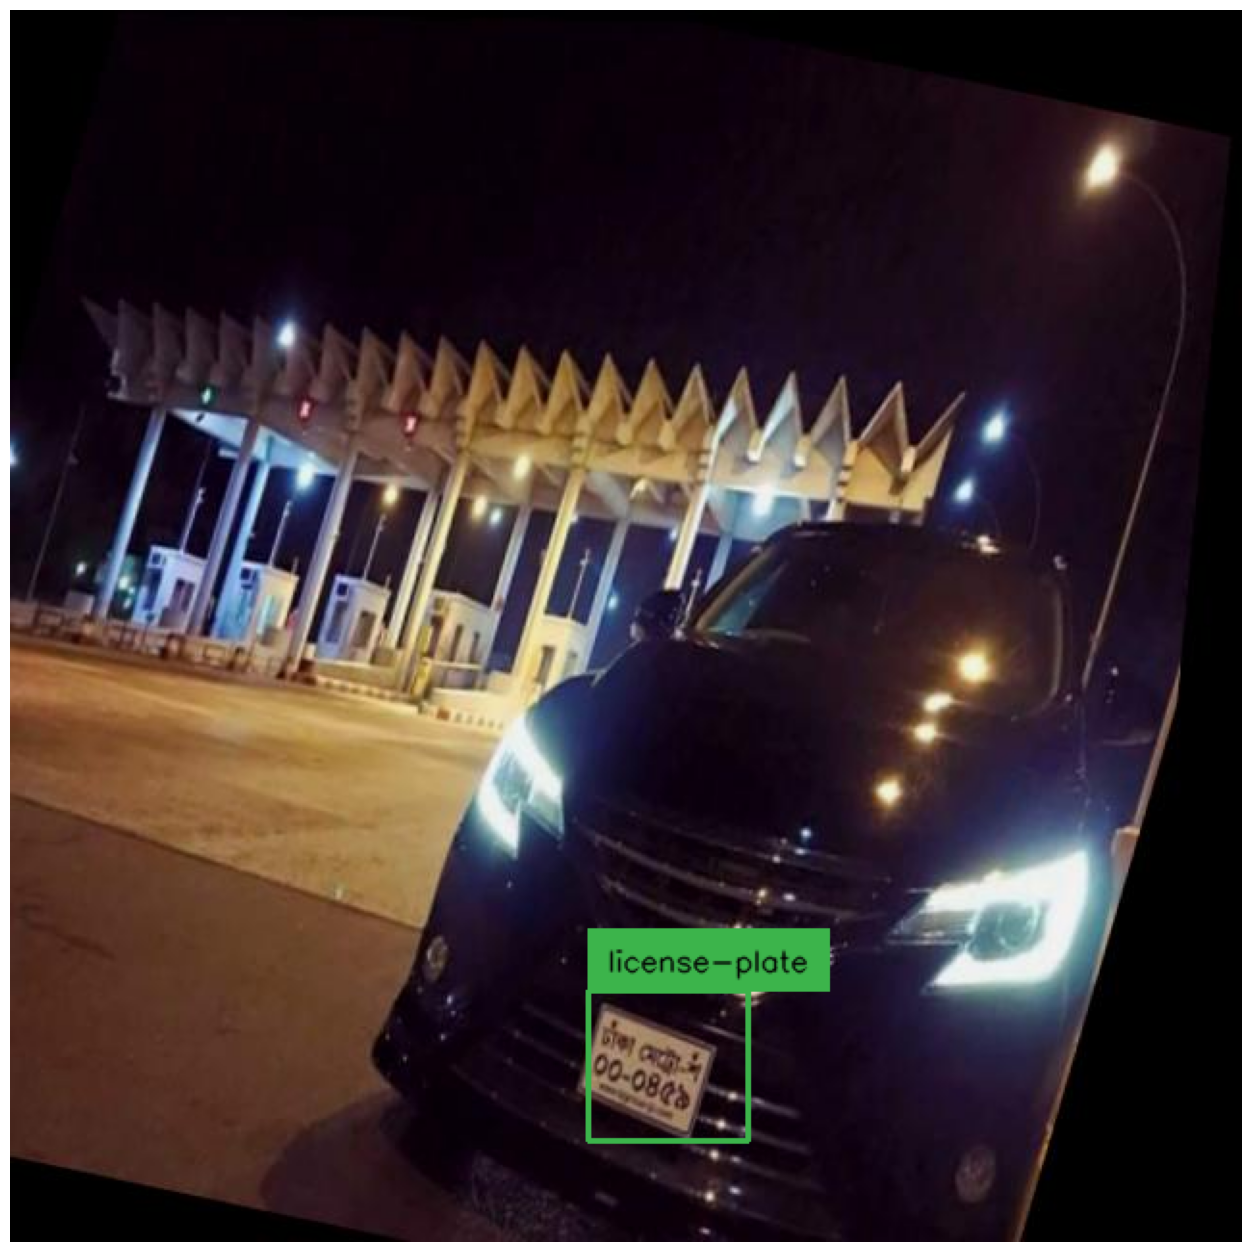

In [11]:
import cv2
import random
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt

image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))
image_info = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image_info['file_name'])
image = cv2.imread(image_path)

if len(annotations) == 0:
    detections = sv.Detections(xyxy=np.empty((0, 4)), class_id=np.empty((0,), dtype=int))
else:
    detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k, v in categories.items()}
print("id2label:", id2label)
labels = [f"{id2label[c]}" for c in detections.class_id] if detections.xyxy.size > 0 else []
labels = ['license-plate' if label == '0' else "Unknown" for label in labels]
print("labels:", labels)
box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

plt.figure(figsize=(16, 16))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### **8. Dataloader Setup**
Instantiates the training, validation, and test datasets and sets up DataLoaders with a custom collate function for batch preparation.

In [12]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

BATCH_SIZE = 4

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=BATCH_SIZE)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=BATCH_SIZE)

print("Number of training batches:", len(TRAIN_DATALOADER))
print("Number of validation batches:", len(VAL_DATALOADER))
print("Number of test batches:", len(TEST_DATALOADER))

Number of training batches: 2877
Number of validation batches: 322
Number of test batches: 321


### **9. Model Definition with PyTorch Lightning**
Wraps the RTDETR model inside a PyTorch Lightning module; defines forward propagation, training/validation steps, and optimizer configuration.

In [13]:
import pytorch_lightning as pl

class RTDetrPLModel(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = RTDetrV2ForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
        loss = outputs.loss
        loss_dict = outputs.loss_dict
        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())
        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
        return loss

    def configure_optimizers(self):
        param_dicts = [
            {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {"params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad], "lr": self.lr_backbone},
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

### **10. Model Training**
Configures and initiates training using PyTorch Lightning’s Trainer with settings for max epochs, gradient clipping, and accumulation.

In [14]:
LOG_DIR = os.path.join(HOME, "logs/rtdetr")
%cd {LOG_DIR}

/home/iot/bd-lpr-rtdetr-trocr-swin2sr/logs/rtdetr


In [14]:
from pytorch_lightning import Trainer
import torch

torch.set_float32_matmul_precision('medium')

SAVED_CHECKPOINT = os.path.join(HOME, "logs/rtdetr/lightning_logs/version_3/checkpoints/epoch=63-step=23040.ckpt")
model = RTDetrPLModel.load_from_checkpoint(
    SAVED_CHECKPOINT,
    lr=1e-4, 
    lr_backbone=1e-5, 
    weight_decay=1e-4
)

batch = next(iter(TRAIN_DATALOADER))
batch = {
    key: value.to(DEVICE) if isinstance(value, torch.Tensor) else value 
    for key, value in batch.items()
}
model.to(DEVICE)
model.train()
print("Model is ready for training.")
print("Batch size:", batch['pixel_values'].shape[0])

# trainer = Trainer(
#     devices=1,
#     accelerator="gpu",
#     max_epochs=82,
#     gradient_clip_val=0.1,
#     accumulate_grad_batches=8,
#     log_every_n_steps=5
# )

# trainer.fit(model, ckpt_path=SAVED_CHECKPOINT)

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r101vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.deco

Model is ready for training.
Batch size: 4


### **11. Inference on a Test Image**
Selects a random test image, performs inference, annotates both ground truth and predictions, and displays the results.

Image #99
id2label: {0: 'license-plate', 1: '0'}
labels: ['license-plate']

Ground Truth


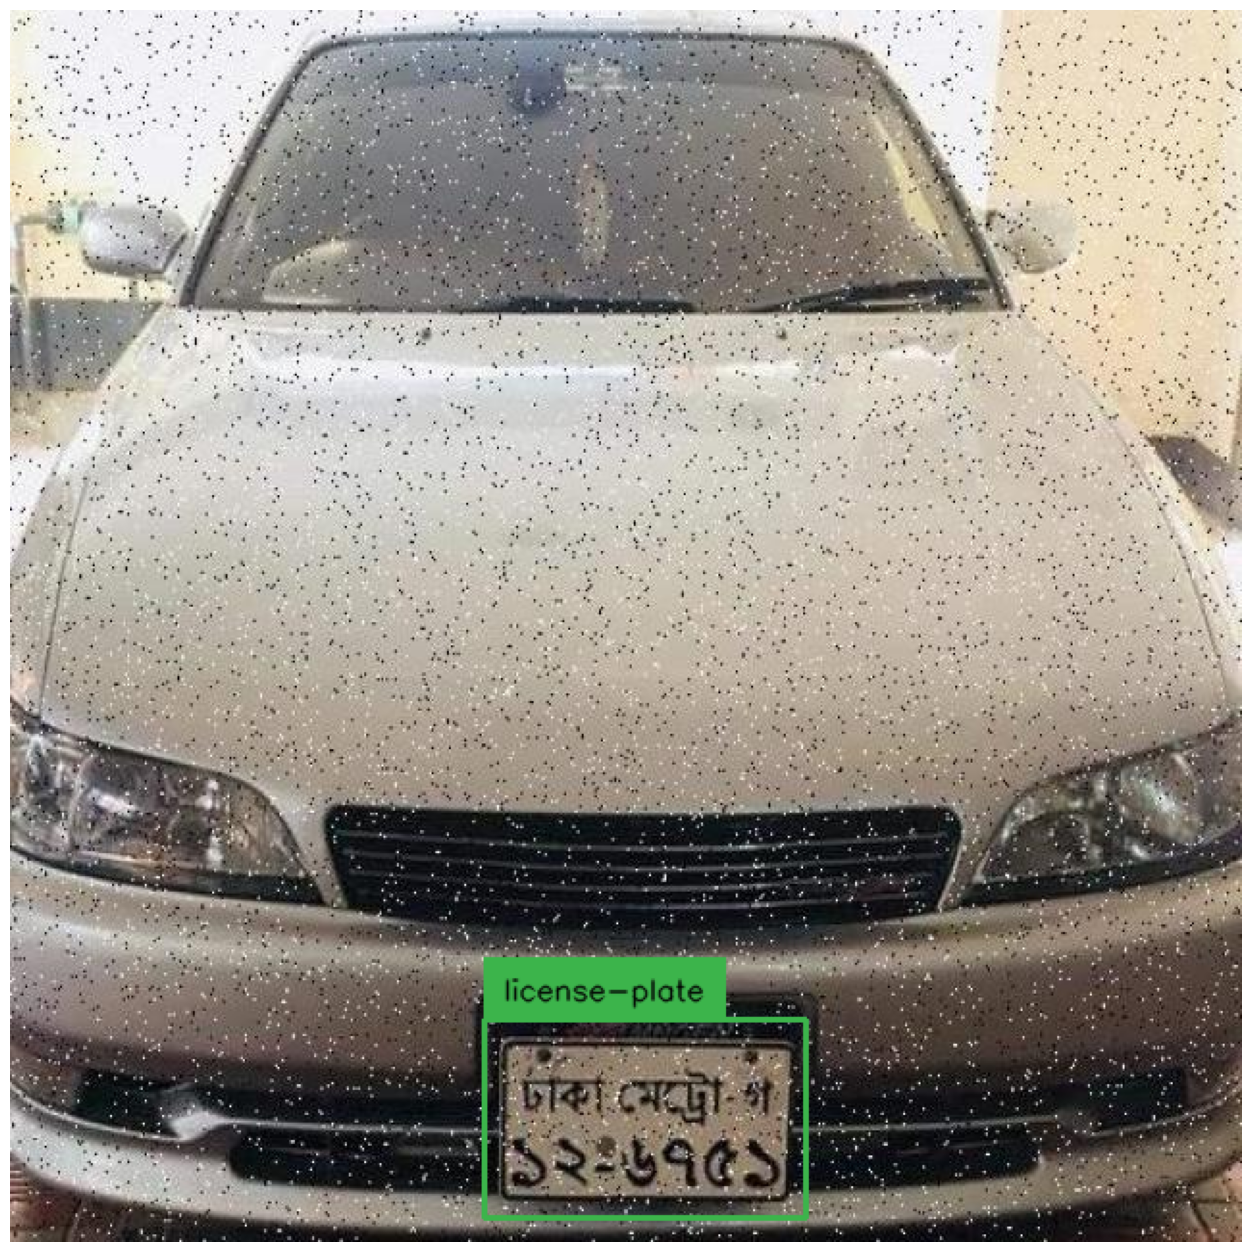

Confidences: [0.8705537]
labels: ['license-plate 0.87']

Predictions


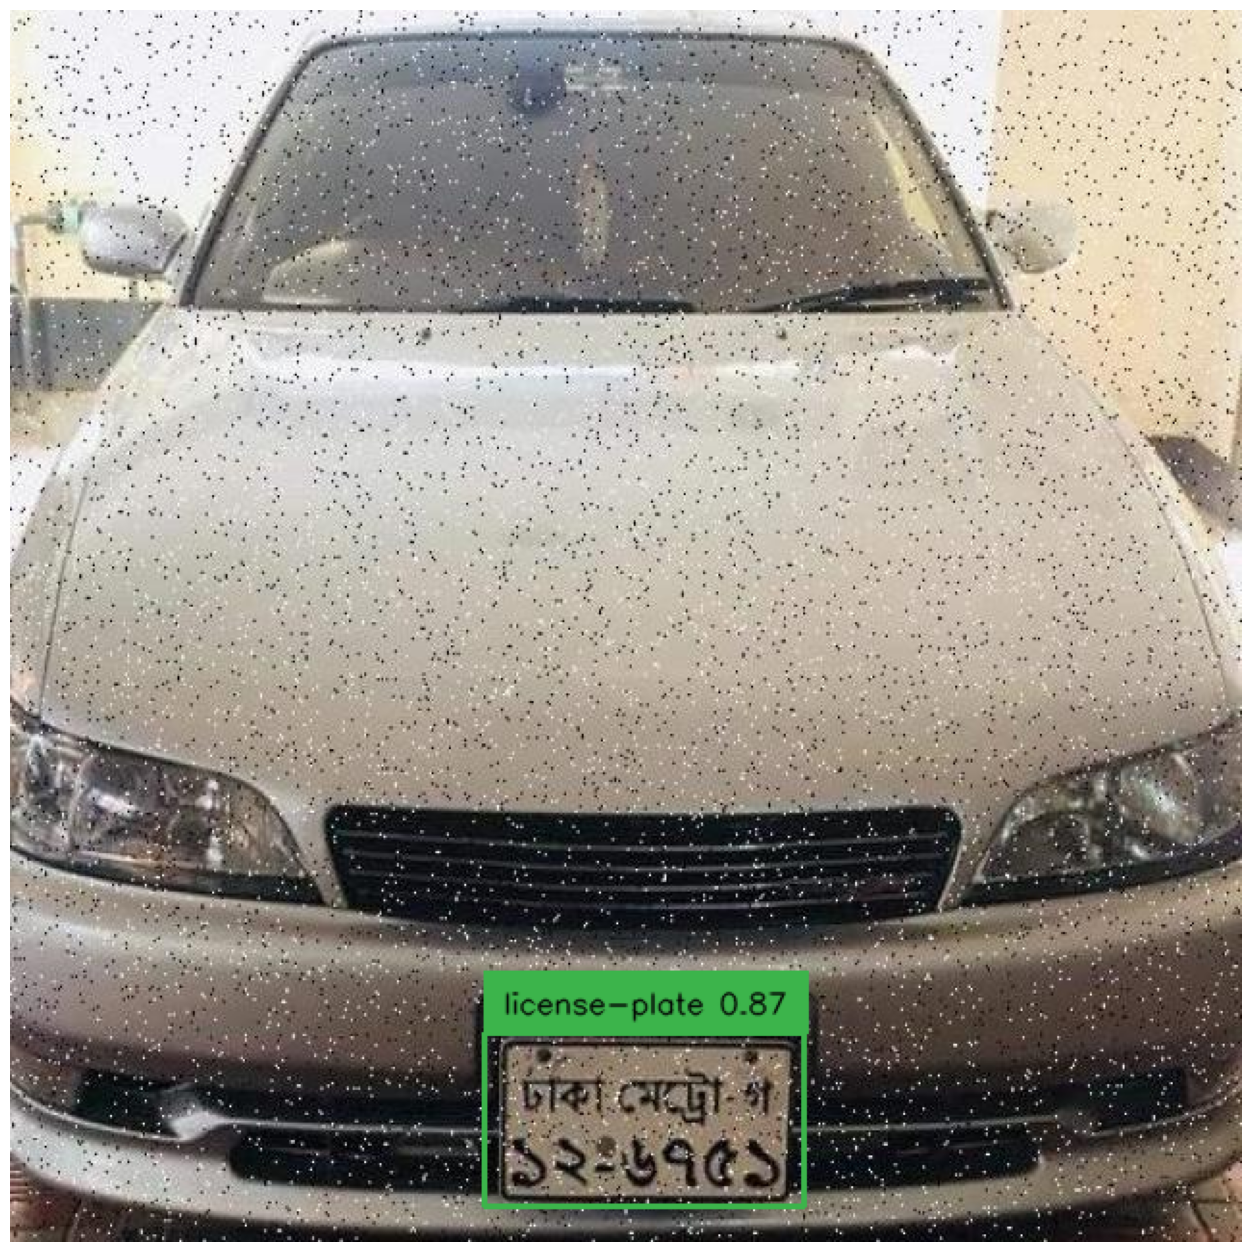

In [36]:
import os
import cv2
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import supervision as sv

model.to(DEVICE)

# Get a random image from dataset
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print(f'Image #{image_id}')

image_info = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns.get(image_id, [])
image_path = os.path.join(TEST_DATASET.root, image_info['file_name'])

# Load image
image = cv2.imread(image_path)

# Handle ground truth annotations
if len(annotations) == 0:
    detections = sv.Detections(
        xyxy=np.empty((0, 4)),
        class_id=np.empty((0,), dtype=int)
    )
else:
    try:
        detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
    except ValueError as e:
        print(f"Skipping image {image_id} due to annotation error: {e}")
        detections = sv.Detections(
            xyxy=np.empty((0, 4)),
            class_id=np.empty((0,), dtype=int)
        )

print("id2label:", id2label)

# Assign labels
labels = [f"{id2label[c]}" for c in detections.class_id] if detections.xyxy.size > 0 else []
labels = ['license-plate' if label == '0' else "Unknown" for label in labels]
print("labels:", labels)

# Annotate ground truth
box_annotator = sv.BoxAnnotator()
frame_gt = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Show ground truth
print('\nGround Truth')
plt.figure(figsize=(16, 16))
plt.imshow(cv2.cvtColor(frame_gt, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Run prediction
model.eval()
with torch.no_grad():
    inputs = image_processor(images=image, return_tensors='pt')
    inputs = image_processor.pad(inputs['pixel_values'], return_tensors='pt')
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# Convert model predictions to Detections with NMS
detections = sv.Detections(
    xyxy=results["boxes"].cpu().numpy(),
    class_id=results["labels"].cpu().numpy(),
    confidence=results["scores"].cpu().numpy()
).with_nms(threshold=0.5)

print("Confidences:", detections.confidence)

# Assign predicted labels
labels = []
for class_id, score in zip(detections.class_id, detections.confidence):
    class_name = id2label.get(class_id, 'Unknown')
    display_name = 'license-plate' if class_name == '0' else class_name
    labels.append(f"{display_name} {score:.2f}")
print("labels:", labels)

# Annotate predictions
frame_pred = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Show predictions
print('\nPredictions')
plt.figure(figsize=(16, 16))
plt.imshow(cv2.cvtColor(frame_pred, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


### **12. Evaluation using COCO Metrics**
Loops over the test dataloader to evaluate model performance with a COCO evaluator calculating metrics like IOU and confidence.

In [38]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tqdm.notebook import tqdm

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    annotation_id = 1  # Initialize annotation ID counter
    
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        for k, (box, score, label) in enumerate(zip(boxes, scores, labels)):
            coco_results.append({
                "id": annotation_id,  # Unique ID for each annotation
                "image_id": original_id,
                "category_id": label,
                "bbox": box,
                "score": score,
                "area": box[2] * box[3],  # width * height
                "iscrowd": 0
            })
            annotation_id += 1
    
    return coco_results

def evaluate_coco(coco_gt, predictions):
    # Create COCO object for predictions
    coco_dt = COCO()
    if len(predictions) > 0:
        coco_dt.dataset = {
            'images': coco_gt.dataset['images'],
            'categories': coco_gt.dataset['categories'],
            'annotations': predictions
        }
        coco_dt.createIndex()

        # Evaluate
        coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        return coco_eval
    else:
        print("No predictions to evaluate")
        return None

# Update the evaluation loop
print("Running evaluation...")
all_predictions = []

for idx, batch in enumerate(tqdm(TEST_DATALOADER, desc="Evaluating Model")):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(
        outputs, 
        target_sizes=orig_target_sizes
    )

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    batch_predictions = prepare_for_coco_detection(predictions)
    all_predictions.extend(batch_predictions)

# Run evaluation
coco_eval = evaluate_coco(TEST_DATASET.coco, all_predictions)

if coco_eval is not None:
    print("Evaluation completed successfully.")
else:
    print("No evaluation results to display.")

Running evaluation...


Evaluating Model:   0%|          | 0/321 [00:00<?, ?it/s]

creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50

### **13. Model Saving**
Saves the trained model and image processor for future reloading and inference.

In [ ]:
MODEL_PATH = os.path.join(HOME, 'rtdetr')
model.model.save_pretrained(MODEL_PATH)
image_processor.save_pretrained(MODEL_PATH)

['/home/iot/bd-lpr-rtdetr-trocr-swin2sr/rtdetr/preprocessor_config.json']

### **14. Model Reload for Inference**
Reloads the saved model and image processor, sets up the id-to-label mapping, and moves the model to the appropriate device.

In [ ]:
%cd {HOME}

/home/iot/bd-lpr-rtdetr-trocr-swin2sr


In [ ]:
from transformers import RTDetrImageProcessor, RTDetrV2ForObjectDetection

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = RTDetrV2ForObjectDetection.from_pretrained("rtdetr")
processor = RTDetrImageProcessor.from_pretrained("rtdetr")
model.config.id2label = {0: "Unknown", 1: "License Plate"}
model.to(device)
model.eval()

RTDetrV2ForObjectDetection(
  (model): RTDetrV2Model(
    (backbone): RTDetrV2ConvEncoder(
      (model): RTDetrResNetBackbone(
        (embedder): RTDetrResNetEmbeddings(
          (embedder): Sequential(
            (0): RTDetrResNetConvLayer(
              (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (normalization): RTDetrV2FrozenBatchNorm2d()
              (activation): ReLU()
            )
            (1): RTDetrResNetConvLayer(
              (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (normalization): RTDetrV2FrozenBatchNorm2d()
              (activation): ReLU()
            )
            (2): RTDetrResNetConvLayer(
              (convolution): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (normalization): RTDetrV2FrozenBatchNorm2d()
              (activation): ReLU()
            )
          )
          (pooler)

### **15. Video Inference**
Processes a video file frame-by-frame for detection, annotates each frame, and writes the results to an output video.

In [ ]:
import cv2
from tqdm.notebook import tqdm
import supervision as sv

# Open video
video_path = "/home/iot/Downloads/License Plate Detection Test.mp4"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Cannot open video")
    exit()

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"Video: {total_frames} frames, {fps} FPS, {width}x{height}")

# Set up output video
output_path = "rtdetr_output_video_3.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Initialize annotator
box_annotator = sv.BoxAnnotator()

# Process frames
pbar = tqdm(total=total_frames, desc="Processing")
for _ in range(total_frames):
    ret, frame = cap.read()
    if not ret:
        print(f"Skipped frame {_}")
        pbar.update(1)
        continue

    with torch.no_grad():
        # Preprocess and infer
        inputs = processor(images=frame, return_tensors='pt')
        inputs = processor.pad(inputs['pixel_values'], return_tensors='pt')
        inputs.to(device)
        outputs = model(**inputs)
        target_sizes = torch.tensor([frame.shape[:2]]).to(device)
        results = processor.post_process_object_detection(
            outputs=outputs, threshold=0.5, target_sizes=target_sizes
        )[0]

    # Annotate
    detections = sv.Detections.from_transformers(transformers_results=results)
    annotated_frame = box_annotator.annotate(
        scene=frame, detections=detections, labels=[f"{model.config.id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    )

    # Write frame
    out.write(annotated_frame)
    pbar.update(1)

pbar.close()

# Release resources
cap.release()
out.release()
print(f"Output saved to {output_path}")

Video: 1800 frames, 30.0 FPS, 640x360


Processing:   0%|          | 0/1800 [00:00<?, ?it/s]

Output saved to rtdetr_output_video_3.mp4
